<a href="https://colab.research.google.com/github/ihadzic1/Analysis-of-Nutrition-and-Caloric-Intake-Using-Image-Classification-Models/blob/fruit-detection/Food_Detection_Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install required libraries
!pip install ultralytics roboflow

In [ ]:
#import dependencies
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from google.colab import files




#Food Object Detection Using YOLOv8

##Introduction:
This project focuses on training a deep learning model to detect food items in images using the YOLOv8x architecture and a custom dataset provided by Roboflow. Food detection has various real-world applications in areas such as health monitoring, nutrition tracking, calorie estimation, and dietary analysis. This model is supposed to serve as part of a working prototype with plans for further improvements.

The following notebook demonstrates the full pipeline — from dataset import and model training to evaluation and visualization of the results — providing a comprehensive overview of the model’s performance on food detection tasks.

##Dataset
Dataset used for training the model is a Roboflow dataset made up from a combination of a custom datset and a dataset from Roboflow Universe (See details in DATASET.md). Several preprocessing and data augmentation techniques were used in the making of the dataset.
<br>
**Preprocessing techniques**:<br>
>**Auto-Orient** (automatically adjusts the image orientation based on its EXIF metadata; for example, rotates images that were taken upside down or sideways)<br>
>**Resize (640x640)** (resizes all images to 640×640 pixels; this is the standard input resolution expected by YOLOv8 models)<br>

**Data augmentation tecniques**:<br>
>**Flip (horizontal, vertical)** (mirrors the image horizontally and/or vertically to simulate different viewing angles and improve model generalization)<br>
>**90° rotate** (rotates the image by 90 degrees clockwise or counterclockwise, helping the model learn from different orientations)<br>
>**Crop** (removes parts of the image edges, focusing on central or random regions to simulate zoom or partial views of the object)<br>
>**Rotation** (rotates the image by a random angle — not limited to 90° — to expose the model to varied object orientations)

In [ ]:
#Import the dataset from roboflow with the following code
rf = Roboflow(api_key="gbnE2mI51TkywHQXfMAH")
project = rf.workspace("foodobjectdetection-gbrbd").project("foodobjectdetectiondataset")
version = project.version(8)
dataset = version.download("yolov8")


##Model
The model is built using transfer learning, where a pre-trained YOLOv8x model is fine-tuned on a specialized food detection dataset. The dataset is imported directly from Roboflow in YOLO format, which ensures seamless compatibility with the ultralytics training pipeline.
<br><br>
Training is performed on a GPU to accelerate computation, using 20 epochs, an image resolution of 640×640, and a batch size of 16.
###Model architecture YOLOv8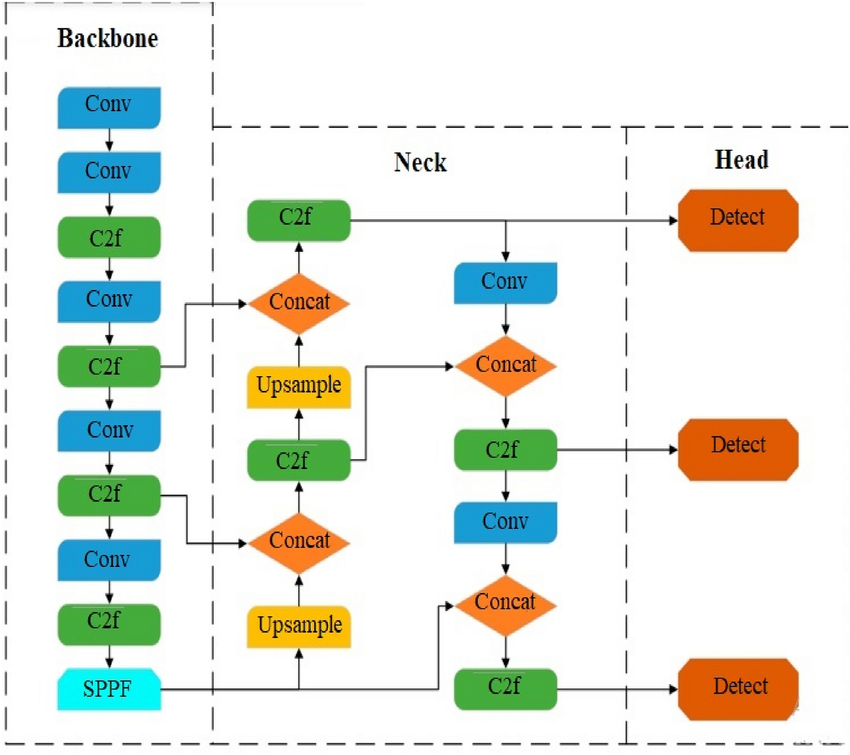

###YOLOv8 Architecture – Key Components
>**Conv**: Standard convolutional layer used to extract features from the input image using kernels, stride, and padding.

>**C2f**: "Cross Stage Partial with 2 convolution blocks" – an efficient variant of CSP blocks that reduces the number of parameters while maintaining performance.

>**Concat**: Concatenates tensors from different layers to combine multi-scale feature information (commonly used in encoder-decoder skip connections).

>**Upsample**: Increases the spatial resolution of feature maps (usually via nearest-neighbor interpolation) to enable fusion with higher-resolution features.

>**Detect**: The final detection head that predicts bounding box coordinates, object classes, and confidence scores for each detected object.

In [ ]:
model = YOLO("yolov8x.pt")  # Using YOLOv8x as base (transfer learning)
dataset_location = dataset.location # Set dataset location

results = model.train(
    data=f"{dataset_location}/data.yaml",
    epochs=20,         # Set number of epochs
    imgsz=640,        # Set image size
    batch=16,        # Determine batch size
    device=0        # GPU = 0; use 'cpu' if no GPU
)


##Model Evaluation
After training, the model is evaluated using standard object detection metrics: mAP@0.5, mAP@0.5:0.95, mean precision, and mean recall, both globally and per class. The results are visualized through various plots for better interpretation.

Finally, a normalized confusion matrix is generated to visualize model performance across classes, and the trained model is zipped and prepared for download for future deployment or inference tasks.


In [ ]:
val_results = model.val(data=f"{dataset_location}/data.yaml")

metrics = val_results

In [44]:
print("\n--- Evaluation Metrics ---")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision (mean): {metrics.box.mp:.4f}")
print(f"Recall (mean): {metrics.box.mr:.4f}")

class_names = model.names
num_metrics = len(metrics.box.p)

print("\nPer-Class Metrics:")
print(f"{'Class':15s} | {'Precision':>9} | {'Recall':>7} | {'AP@0.5':>7} | {'AP@0.5:0.95':>12}")
print("-" * 60)

for i in range(num_metrics):
    name = class_names[i]
    p = metrics.box.p[i]
    r = metrics.box.r[i]
    ap50 = metrics.box.ap50[i]
    ap = metrics.box.ap[i]
    print(f"{name:15s} | {p:.2f}       | {r:.2f}   | {ap50:.2f}   | {ap:.2f}")


--- Evaluation Metrics ---
mAP@0.5: 0.0275
mAP@0.5:0.95: 0.0128
Precision (mean): 0.0474
Recall (mean): 0.0529

Per-Class Metrics:
Class           | Precision |  Recall |  AP@0.5 |  AP@0.5:0.95
------------------------------------------------------------
person          | 0.01       | 0.09   | 0.01   | 0.01
bicycle         | 0.01       | 0.00   | 0.00   | 0.00
car             | 0.00       | 0.00   | 0.00   | 0.00
motorcycle      | 0.00       | 0.00   | 0.00   | 0.00
airplane        | 0.05       | 0.21   | 0.04   | 0.04
bus             | 0.00       | 0.12   | 0.00   | 0.00
train           | 0.09       | 0.08   | 0.05   | 0.03
truck           | 0.00       | 0.00   | 0.00   | 0.00
boat            | 0.00       | 0.00   | 0.00   | 0.00
traffic light   | 0.00       | 0.00   | 0.00   | 0.00
fire hydrant    | 0.02       | 0.07   | 0.01   | 0.01
stop sign       | 0.40       | 0.06   | 0.21   | 0.07


###Precision, Recall and mAP@0.5 per class
**Precision**:<br>
What it measures: Of all predicted positives, how many are actually correct.
Indicates how reliable the model is when it predicts a positive.
<br><br>
**Recall**:<br>
What it measures: Of all actual positives, how many the model successfully detected.
Shows how well the model finds all true positive cases.
<br><br>
**mAP@0.5**:<br>
What it measures: The average precision across all classes at a 0.5 IoU threshold.
Reflects the overall accuracy of the model balancing precision and recall.

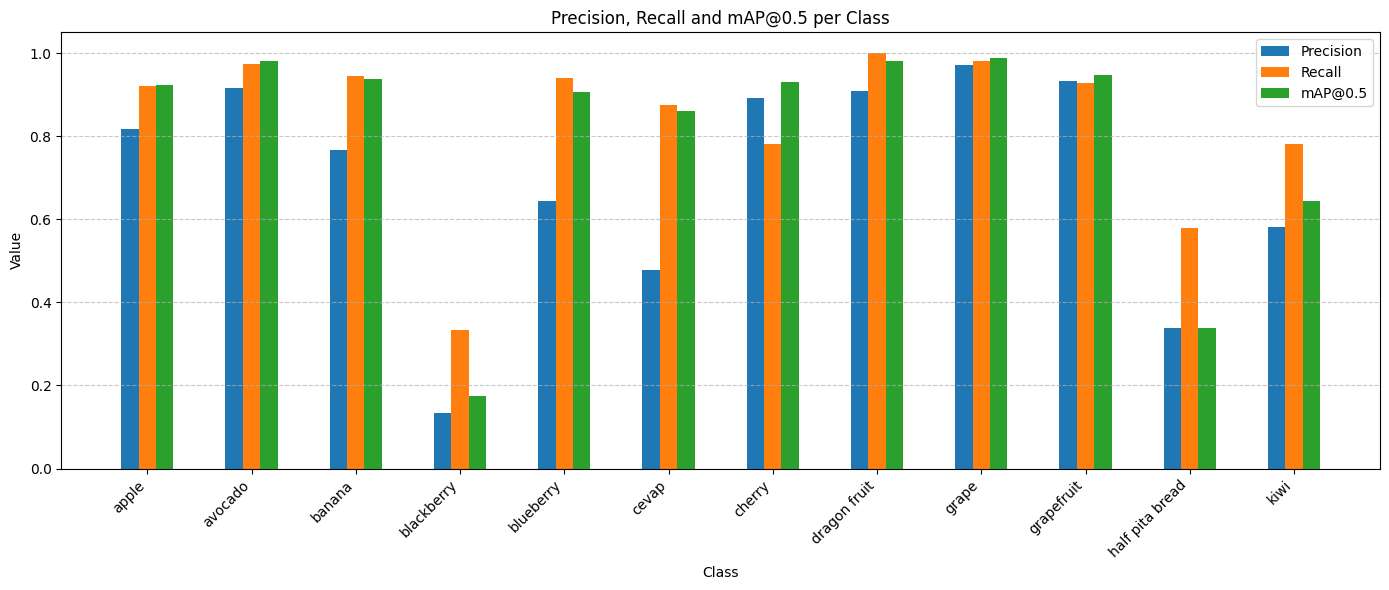

In [18]:
#Plot the results
class_names = list(model.names.values())
precision = metrics.box.p
recall = metrics.box.r
map50 = metrics.box.ap50

num_metrics = len(precision)

spacing = 1.5
x = np.arange(num_metrics) * spacing

plt.figure(figsize=(14, 6))
bar_width = 0.25

plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='tab:blue')
plt.bar(x, recall, width=bar_width, label='Recall', color='tab:orange')
plt.bar(x + bar_width, map50, width=bar_width, label='mAP@0.5', color='tab:green')

plt.xticks(x, class_names[:num_metrics], rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.xlabel('Class')
plt.ylabel('Value')
plt.title('Precision, Recall and mAP@0.5 per Class')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


###Interpretation of results (Precision, Recall and mAP@0.5 per class)
Based on the graph, the model generally performs well overall, except for certain classes such as blackberry, half pita bread, and kiwi. These classes exhibit lower precision, recall, and mAP@0.5 values, indicating that the model often misclassifies or misses instances of these categories.

###F1 curve, PR Curve, P curve, R curve

**F1 Curve**<br>
What it measures: How the harmonic mean of precision and recall changes at different thresholds.<br>
Indicates: The balance between precision and recall, showing the best trade-off point for the model’s classification performance.

<br><br>

**PR Curve (Precision-Recall Curve)**<br>
What it measures: The relationship between precision and recall across different confidence thresholds.<br>
Indicates: How precision decreases as recall increases, helping to evaluate model performance especially on imbalanced datasets.<br>

<br><br>

**P Curve (Precision Curve)**<br>
What it measures: How precision changes as the classification threshold varies.<br>
Indicates: The model’s reliability in positive predictions at different confidence levels.

<br><br>

**R Curve (Recall Curve)**<br>
What it measures: How recall changes as the classification threshold varies.<br>
Indicates: The model’s ability to find true positives at different confidence levels.



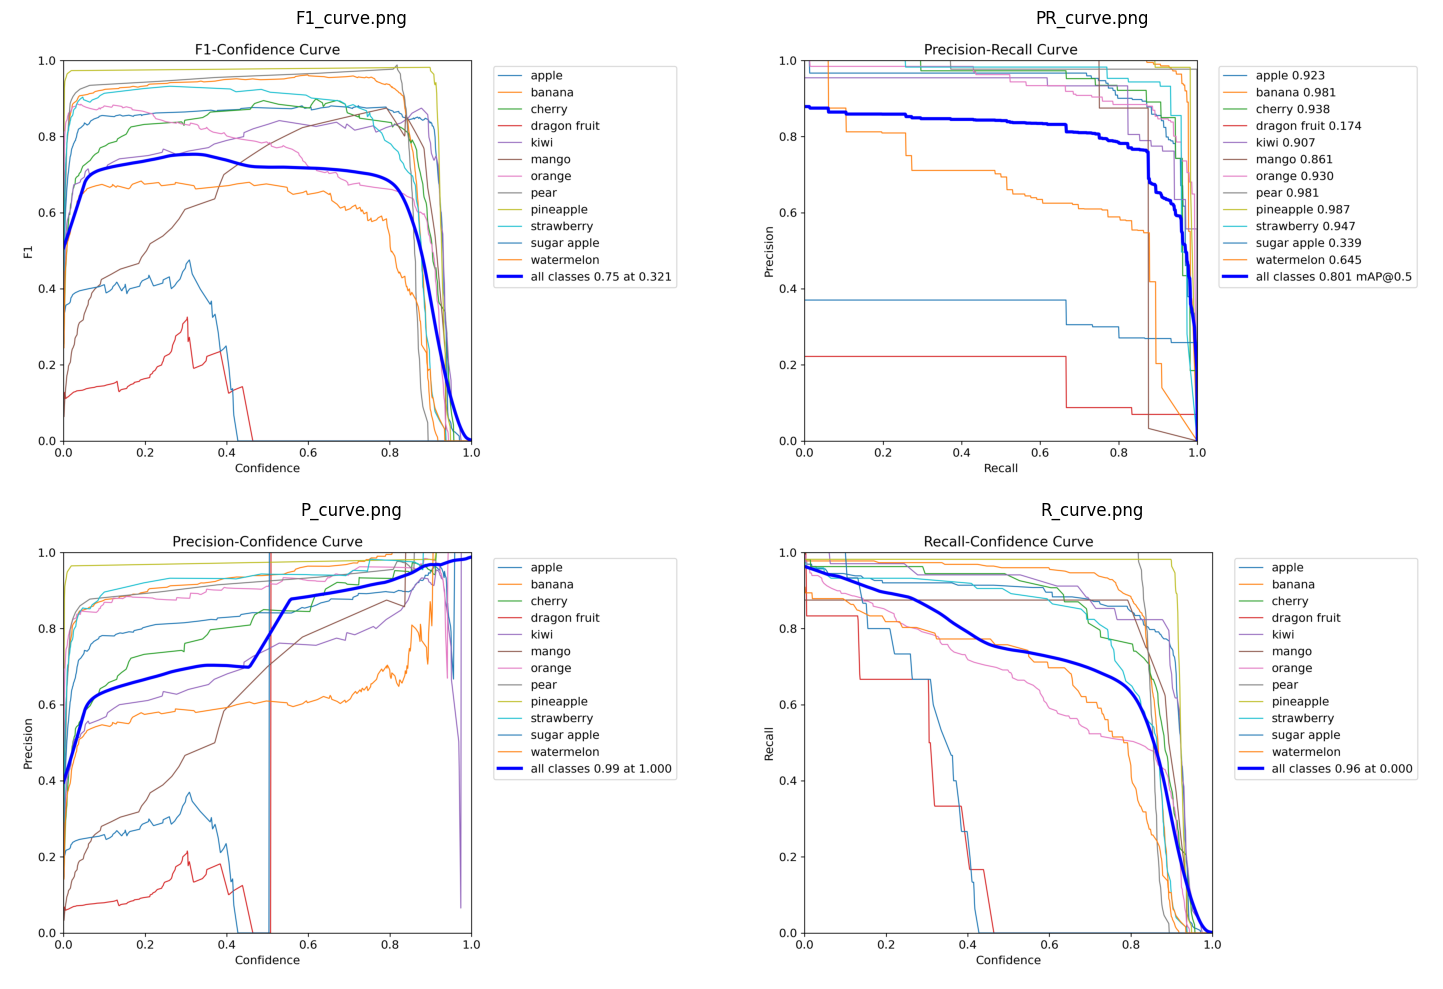

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lista imena slika koje želiš prikazati
image_files = ['F1_curve.png', 'PR_curve.png', 'P_curve.png', 'R_curve.png']

plt.figure(figsize=(15, 10))

for i, file in enumerate(image_files):
    img = mpimg.imread('runs/detect/train3/'+file)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()


###Interpretation of results (F1 curve, PR Curve, P curve, R curve)
F1 confidence score around 0.6-0.9 for most classes remains stable until confidence 0.9, then drops — meaning the model keeps a good balance between precision and recall up to that point, but becomes too strict above 0.9, losing some true positives and lowering recall.

PR curve shows precision steadily decreasing as recall increases, with the largest drop occurring around recall 0.9 — indicating that as the model tries to find more true positives, it also includes more false positives, especially near high recall values.

Precision confidence curve steadily increases for most classes — meaning that as the confidence threshold rises, the model’s positive predictions become more reliable.

Recall confidence curve decreases as the confidence threshold increases — indicating that as the model becomes more confident in its predictions, it identifies fewer true positives, lowering recall.



###Confusion matrix
**Confusion matrix** is a table that shows the number of correct and incorrect predictions made by the model, broken down by each class.
It indicates how well the model is performing for each class by displaying true positives, false positives, false negatives, and true negatives, helping identify which classes are often confused with each other.

Classes in CM: 24, Classes in model.names: 23


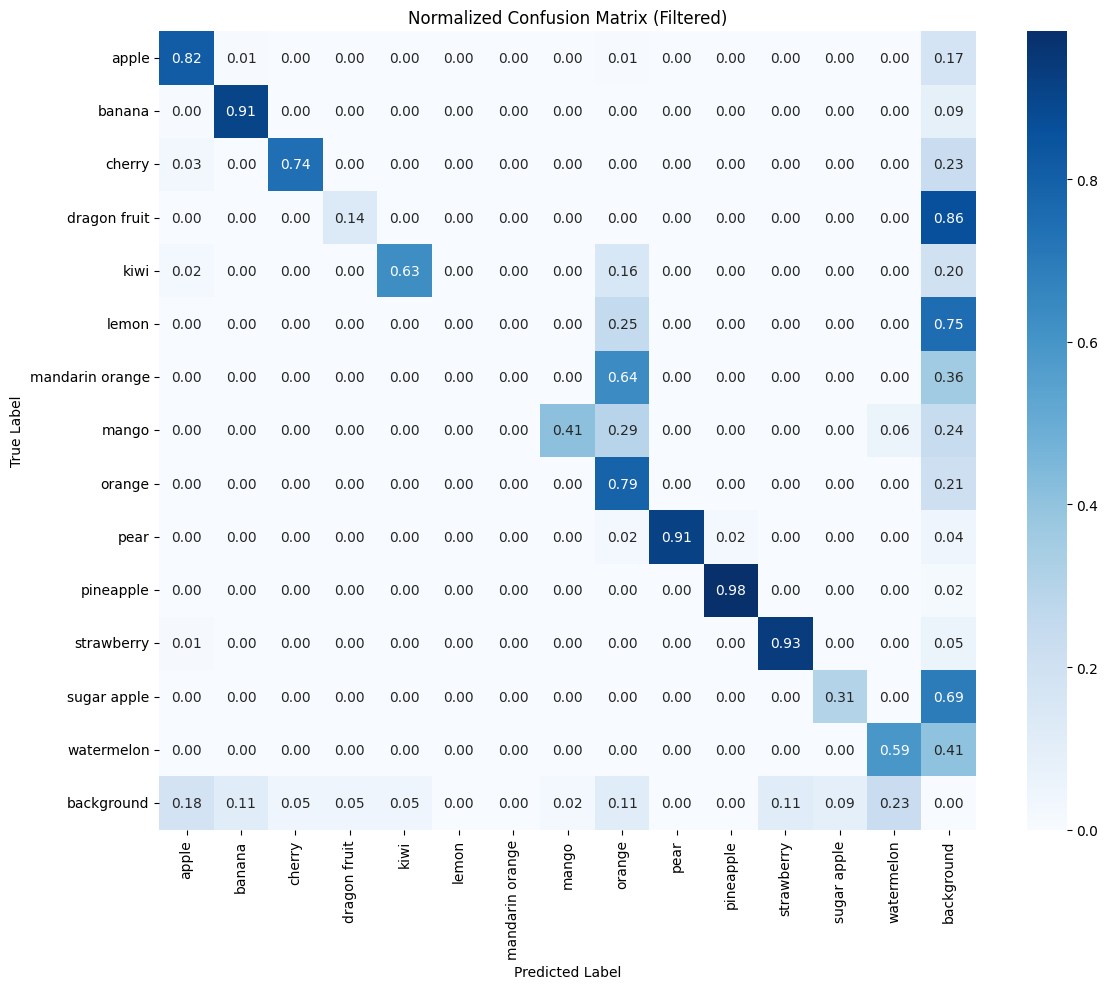

In [36]:
import numpy as np

num_classes_cm = cm.shape[0]

#Get the number of classes
num_classes_names = len(model.names)  # 23

print(f"Classes in CM: {num_classes_cm}, Classes in model.names: {num_classes_names}")

class_names = list(model.names.values())
if num_classes_cm > num_classes_names:
    class_names.append("background")

classes_to_remove = ['blackberry', 'cevap', 'avocado', 'blueberry', 'grape', 'grapefruit', 'raspberry', 'slice of bread', 'half pita bread']

indices_to_remove = [class_names.index(c) for c in classes_to_remove if c in class_names]

mask = np.ones(num_classes_cm, dtype=bool)
mask[indices_to_remove] = False

cm_sum = cm.sum(axis=1, keepdims=True)
cm_sum[cm_sum == 0] = 1
cm_normalized = cm.astype(float) / cm_sum

cm_filtered = cm_normalized[mask][:, mask]
filtered_labels = [name for i, name in enumerate(class_names) if mask[i]]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm_filtered, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=filtered_labels,
            yticklabels=filtered_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Filtered)")
plt.tight_layout()
plt.show()


###Interpretation of results (Confusion matrix)
Based on the analysis of the confusion matrix, we can conclude that the model generally performs well on the classes present in the test dataset, correctly detecting and classifying most food items. However, it struggles with classifying lemons and mandarin oranges, often misclassifying them as regular oranges. To achieve optimal results, the model requires more training data.

##Export the model

In [ ]:
#Zip the model
!zip -r best_model_x.zip runs/detect/train/weights/

#Download the model
files.download("best_model_x.zip")
